# Introduction

Our newest customer, Jane Doe, has a 7 year old child, Ralph, who recently just started up his first semester of 2nd grade! Jane is super happy and the best part for her is that the school offers a free bus system that passes by her house so her son can take the bus to and from school. The only problem is that the kids need to get across a crosswalk to get to the bus since the parking lot is too busy and packed for the bus to get in. Jane is worried about her son and the other younger kids crossing the crosswalk without a safety guard instructor and the stop sign that is located there is covered by a lot of brush so cars tend to not notice it. 

Jane has an idea to create a sign that takes a picture and then emits a bright flashing red STOP and yellow SLOW sign to let oncoming cars know to slow down and stop to let the kids cross if the picture is a vehicle image. Our job is to create the vehicle classification system that classifies the oncoming traffic as a vehicle or non-vehicle and activates the flashing STOP and SLOW signs really bright based on the result. Luckily we just got our hands on a nice dataset containing images of vehicles and non-vehicles to put to use!

In [1]:
#import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import cv2
import random 
import re 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.xception import Xception
from keras import Input, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint, LearningRateScheduler


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from mlxtend.plotting import plot_confusion_matrix

# Data Loading/Wrangling

Since we are dealing with images and not csv's we have to be a little more crafty other than just reading in a csv. Using OPENCV libaries we loop through our categories and combine that with matplotlib to display our images and data. 

In [2]:
#creating a directory variable where our dataset is located 
DATADIR = r'C:\Users\ebent\Downloads\vehicle detection\data'
#creating a category variable for non-vehicles and vehicles since that is what we are trying to detect
CATEGORIES = ['non-vehicles', 'vehicles']
categories = {'non-vehicles': 0, 'vehicles': 1}

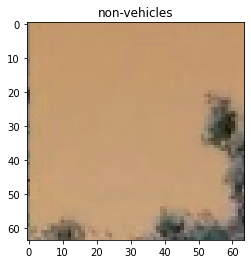

In [3]:
#looping through our categories and going through our directory to display our images

for category in CATEGORIES: 
    path = os.path.join(DATADIR, category) #path to our images
    for img in os.listdir(path): 
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
        plt.imshow(img_array)
        plt.title(category)
        plt.show()
        break #setting breaks to see only one image
    break #setting breaks to see only one image

So we have our first image! From our perspective right now it isn't a car but just some sky and trees but to our computer it's a bunch of pixels and arrays! 

Next we are going to use the same code from above to create a function that will load all of our images. We will also be adding in some code to resize our images, turn them into arrays, append the images and their labels to separate lists and then scale our data. 

In [4]:
#resizing our images so they are all one size
IMG_SIZE = 112

def load_images(): 
    images = []
    labels = []
    for category in CATEGORIES: 
        path = os.path.join(DATADIR, category) #path to our images
        class_num = CATEGORIES.index(category) #encode categories into integers, in this case [0,1]
        for img in os.listdir(path): 
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            img_array = np.array(img_array) 
            images.append(img_array)
            labels.append(category)
            
    images = np.array(images)
    images = images.astype(np.int64)
    
    for arr in images: #scaling our data, max pixels is 255 
        arr = arr/255

    return images, labels


In [5]:
images, labels = load_images() #apply the function to two empty lists named images and labels

print(len(images)) #checking both the length of our images and labels lists
print(len(labels))

17760
17760


Great! It looks like all 17760 images and labels were loaded in properly based off the length of the lists. Now we need to shuffle our data. When building a CNN classification model, it's imporant that we shuffle the data so that our model doesn't just immediately guess only one of our options. For example if we just have all our vehicle images in a row, then our model is just going to learn to guess "vehicle" and be right 50% of the time. So to prevent this from happening we shuffle the dataset so it actually learns how to classify each image instead of just guessing. To do this we will zip together our lists and then shuffle and unzip them back into their original lists

In [6]:
temp = list(zip(images, labels)) #create a temporary zipped list to shuffle the data
random.shuffle(temp)

images, labels = zip(*temp) #unzip the temporary lists back into their original lists 
images, labels = list(images), list(labels)

In [7]:
#checking if everything is shuffled properly and match the image order
for lab in labels[:10]: 
    print(lab)

non-vehicles
vehicles
non-vehicles
vehicles
non-vehicles
non-vehicles
vehicles
vehicles
vehicles
vehicles


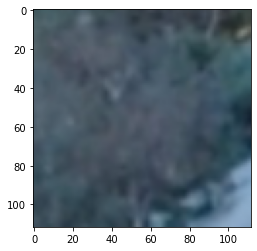

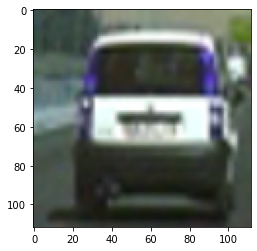

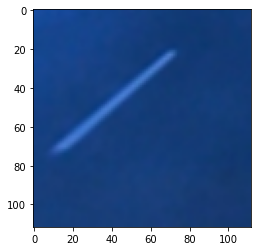

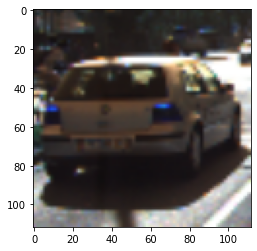

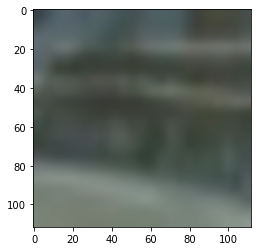

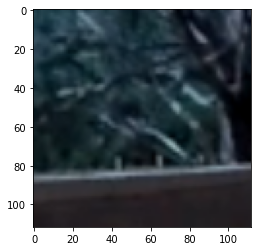

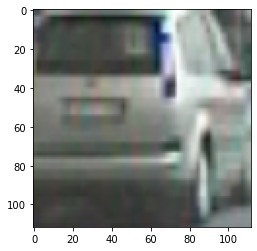

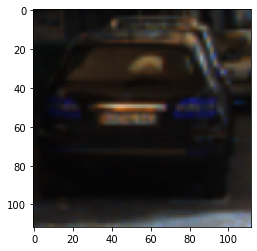

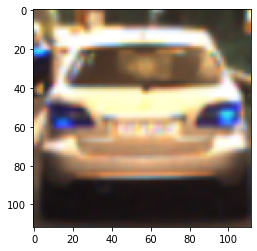

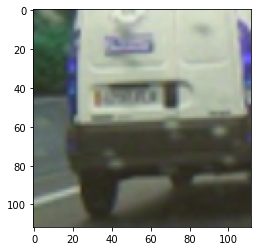

In [8]:
#checking if everything is shuffled properly and labels match the image order
for img in images[:10]: 
    plt.imshow(img)
    plt.show()

Now that everything is shuffled, we are going to label encode our labels. Unfortunately we can't use strings to train our model since models like to work with numbers! Using a label encoder we can turn our 'non-vehicle' strings into the number 0 and our 'vehicle' strings into 1's. 

In [9]:
#using a labelencoder to turn our labels into [0,1] numbers that we can put through our model
label_encoder = LabelEncoder()
labels_enc = label_encoder.fit_transform(labels)

In [10]:
#checking if label encoder worked
for lab in labels_enc[:10]: 
    print(lab)

0
1
0
1
0
0
1
1
1
1


# Data Visualization

Alright now lets take a deeper look at our photos and labels. We should always do some data visualization before we go into training our model. This is to ensure any changes we may need to make such as image sizing if the clarity of the image is not good enough to train the model. 

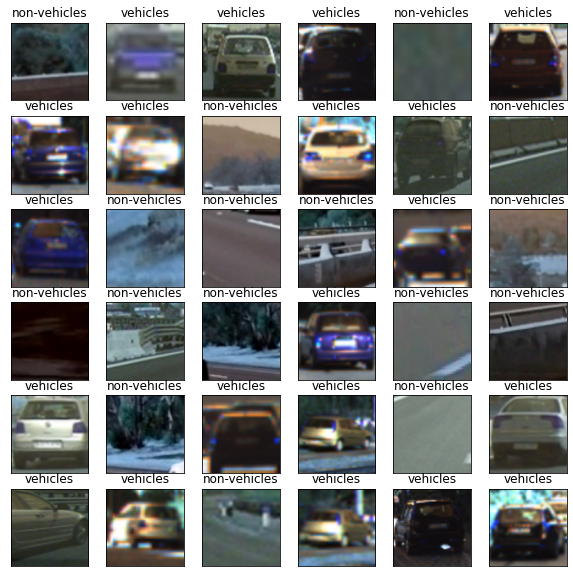

In [11]:
#plot some randomly selected data visualization
plt.figure(figsize=[10,10]) 
random_inds = np.random.choice(17760,36) 

for img in range(36): 
    plt.subplot(6,6,img+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[img]
    plt.imshow(np.squeeze(images[image_ind]), cmap=plt.cm.binary)
    plt.title(labels[image_ind])

Our photos and the labels are looking better than ever! The images are clear and the labels match the images. We also get an idea of what our model will be working with when it's training such as the different angles, colors, etc. Now onto the pre-processing!

# Pre-Processing and Training

For the pre-processing and training portion of the project we first need to resize our images. Training CNN image classification models doesn't take in the array shape that our images are in right now. So to do this we need to turn it into an array and reshape it to the image size that we want our images as. We add a 1 or 3 at the end of the reshape depending on if we have color or greyscale images. The -1 is to reshape all 17760 of our images. 

In [12]:
#reshaping images and labels are required for our model with a 3 since our images are color RGB type images
images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
labels_enc = np.array(labels_enc, dtype=int)

Perfect, now that our images are resized we can split the images into different sets. When working with CNN models it's good to have 3 different sets of data. A training set to train our model on, a validation set to use while training the model for comparison to the training set, and lastly a testing set that will be unseen and used only when the training is finished and test the model on. We are going to use a 70% training, 20% validation, 10% testing but depending on the size of your dataset these splits may change. Usually with smaller datasets you may need larger percentage validation sets. 

In [13]:
#split training data 70% of dataset
X_train = images[:12432]
y_train = labels_enc[:12432]

#split validation data 20% of dataset
X_val = images[12432:15984]
y_val = labels_enc[12432:15984]

#split testing data 10% of dataset
X_test = images[15984:]
y_test = labels_enc[15984:]
y_test_lab = labels[15984:]

The next thing we need to do is to create callbacks. Callbacks are a way to monitor, optimize and view the model during the training state. It's very helpful since models take a long time to train and so we don't want to just wait till the very end to find out how the model is doing. We want to observe it while it's happening. We are going to use tensorboard to log our loss and accuracy, early stopping to stop our model when it is no longer improving and prevent some overfitting, and a learning rate scheduler to modify our learning rates during the epoch training. 

In [14]:
#creating some callbacks

tensorboard = TensorBoard(log_dir = 'logs')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3)
#reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 3, min_delta = 0.001,
#                              mode='auto',verbose=1)
def schedule(epoch,lr):
    if epoch>=5:
        return 0.0001
    return 0.001
learning_rate_scheduler=LearningRateScheduler(schedule)

Now we can get to the fun part! Creating the architecture for our CNN model. We're going to be using a basic CNN model for our training. Sequential models are simple but work very well. The Conv2D deals with our input images which are seen as 2D matrices. 

MaxPool2D downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window for each channel of the input.

Batch Normalization normalizes the contributions to a layer for every mini-batch which decreases the number of epochs we need to train our model and helps prevent overfitting. 

Flatten will connect our convolution layers to our Dense layers which is the standard layer type used in cnn models. 

We are basically going to have 4 layers for the network and the activation function we will be using is relu and sigmoid which are also standard functions. 

In [25]:
#using a sequential model
model = Sequential()

#1st layer of convolutional neural network
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (112,112,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#2nd layer of convolutional neural network
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#3rd layer of convolutional neural network
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#4th and final layer of convolutional neural network
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

We can now compile and fit our model! For our compiling we will use binary crossentropy since our model is binary classification meaning we classify between 2 things which in our case is vehicles or non-vehicles. 

We will stick with an adam optimizer that will help train our data with fewer resources and is very adaptive compared to other optimizers. It is an alternative optimization algorithm that provides more efficient neural network weights by running repeated cycles of “adaptive moment estimation.”

The metrics we will be using is accuracy and loss. 

We shouldn't need too many epochs to train our data so we will stick with 4 for now. 

In [26]:
#compile the model and fit it to our training and validation data

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=4, verbose=1, validation_data=(X_val,y_val), 
          callbacks=[tensorboard,early_stopping,learning_rate_scheduler])

Epoch 1/4
389/389 [==============================] - 384s 982ms/step - loss: 0.1029 - accuracy: 0.9651 - val_loss: 1.5455 - val_accuracy: 0.7979 - lr: 0.0010
Epoch 2/4
389/389 [==============================] - 408s 1s/step - loss: 0.0482 - accuracy: 0.9852 - val_loss: 0.2586 - val_accuracy: 0.9414 - lr: 0.0010
Epoch 3/4
389/389 [==============================] - 447s 1s/step - loss: 0.0286 - accuracy: 0.9917 - val_loss: 0.0689 - val_accuracy: 0.9792 - lr: 0.0010
Epoch 4/4
389/389 [==============================] - 449s 1s/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 0.1146 - val_accuracy: 0.9744 - lr: 0.0010


Amazing! We can managed to achieve great results for accuracy and val_accuracy with each ending at 99.50% and 97.44%. It only took us 4 epochs to train the data and get this accuracy and so far there is no signs of overfitting or underfitting. Each accuracy improved with each epoch or stay pretty much the same and the val accuracy didn't show any red flags.

With this we can evaluate our model on our unseen testing data and see how it turns out. 

In [27]:
#checking our evaluation percentage accuracy
model.evaluate(X_test, y_test)

56/56 [==============================] - 14s 236ms/step - loss: 0.0705 - accuracy: 0.9792


[0.07052214443683624, 0.9791666865348816]

We got very similar results to our epoch training. A 97.92% accuracy on the test set is great and the loss was very minimal as well. Now we should check out some graphs of our accuracy and loss just to get a good visual of how our accuracy and loss are actually rather than just staring at individual numbers. 

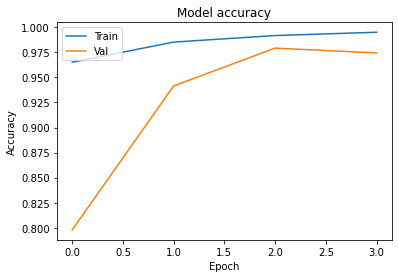

In [28]:
#plotting our model accuracy and val accuracy 

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

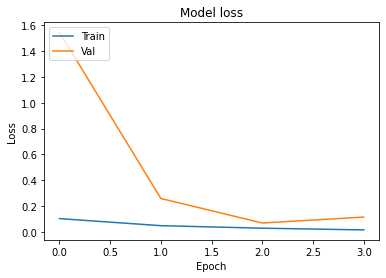

In [29]:
#plotting our model loss and val loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc = "upper left")
plt.show()

Based on our graph we have a good model. The accuracy and loss for the validation set stays below the training set but follows along the line of the training set with only a single small drop in accuracy at the end but that is to be expected. As long as there is no massive drop in accuracy or increase in loss then we should be fine. We can definitely say that our model is good without any over or under fitting. 

# Modeling

Finally we can now make some predictions! With our trained model we can use it to predict what some images are in our testing set. Using the predict method we are going to create a new list of predictions. With those predictions we are going to loop through each prediction and see if the model predicted a vehicle or non-vehicle depending on the number that it returned. The model doesn't exactly return a 0 or 1 but it returns a number very very close to those numbers such as 0.00000000000023 or 1.000000023. So we will round the numbers and then the number should be equal to either 1 or 0 which will tell us if it is a vehicle or non-vehicle. Then from there we will cross reference with our y_test which contains the true label of the image. 

In [30]:
#use model to make predictions on testing data
predictions = model.predict(X_test)

56/56 [==============================] - 11s 196ms/step


In [33]:
#create new list of predictions which we will append our predicted labels to
new_predictions = []

#loop through our predictions and if the number equals 0 then append non-vehicle and if equals 1 append vehicle to our new list
for num in predictions: 
    if np.round(num) == 0: 
        new_predictions.append('non-vehicle') 
    elif np.round(num) == 1: 
        new_predictions.append('vehicle')
        
#print our a random section of our predicted labels and cross reference it to our y_test set
new_predictions[100:120] 

['vehicle',
 'non-vehicle',
 'vehicle',
 'non-vehicle',
 'non-vehicle',
 'vehicle',
 'vehicle',
 'vehicle',
 'non-vehicle',
 'vehicle',
 'vehicle',
 'vehicle',
 'non-vehicle',
 'non-vehicle',
 'vehicle',
 'vehicle',
 'non-vehicle',
 'vehicle',
 'vehicle',
 'non-vehicle']

In [34]:
#referencing to our test set with string labels 
y_test_lab[100:120]

['vehicles',
 'non-vehicles',
 'vehicles',
 'non-vehicles',
 'non-vehicles',
 'vehicles',
 'vehicles',
 'vehicles',
 'vehicles',
 'vehicles',
 'vehicles',
 'vehicles',
 'non-vehicles',
 'non-vehicles',
 'vehicles',
 'vehicles',
 'non-vehicles',
 'vehicles',
 'vehicles',
 'non-vehicles']

In [35]:
#reference to our test set with label encoded labels
y_test[100:120]

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0])

Our model looks like it is performing great with making accurate predictions in the predictions list after being cross referenced with our y_test lists. There is one wrong prediction on the 9th prediction with the model predicting non-vehicle when it is actually a vehicle. But that is to be expected as well since our model is only 97% accurate! Now we didn't necessarily randomize the predictions. I just arbitrarily chose a set of labels and images in the list to use our model on. Next we are going to randomly plot some images from X_test and use the model to predict their label. It is going to be similar to our data visualization code but with the added model prediction. Let's see how it does.

1/1 [==============================] - 0s 26ms/step


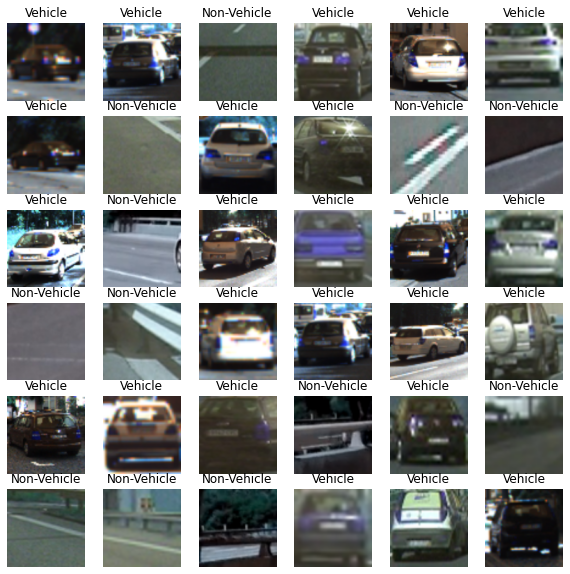

In [36]:
#plot some data visualization by using our model to predict random image labels from our test set 
plt.figure(figsize=(10,10))
for num in range(36): 
    plt.subplot(6,6,num+1)
    rand = np.random.randint(1776)
    pred = model.predict(np.reshape(X_test[rand], (-1,IMG_SIZE,IMG_SIZE,3)))
    if np.round(pred) == 0: 
        plt.title('Non-Vehicle')
    else: 
        plt.title('Vehicle')
    plt.axis('off')
    plt.imshow(X_test[rand])
plt.show()

Based on the looks of it our model was able to accurately predict correctly all of the 36 images that were randomly selected. With this we can conclude our project for Jane Doe! She can trust that our model will be able to accurately predict a vehicle from a non-vehicle and stop cars at the crosswalk for all the children to cross safely!

In [40]:
model.save('vehicle_class.h5')

In [41]:
#imagenet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))

In [42]:
#model_tl = imagenet.output
#model_tl = tf.keras.layers.GlobalAveragePooling2D()(model_tl)
#model_tl = Dropout(0.5)(model_tl)
#model_tl = tf.keras.layers.Dense(2,activation='relu')(model_tl)
#model_tl = Model(inputs=imagenet.input, outputs=model_tl)

In [43]:
#model_tl.summary()

In [44]:
#tf.keras.utils.plot_model(model_tl, show_shapes=True)

In [45]:
#model_tl.compile(optimizer ="adam", loss = "binary_crossentropy", metrics = ['accuracy'])

In [46]:
#model_tl.fit(X_train, y_train, batch_size=32, epochs=1000, verbose=1, validation_data=(X_val,y_val), 
#            callbacks=[tensorboard, checkpoint,early_stopping,reduce_lr])

# Conclusion

Our model ended with a 97.92% accuracy rating with no signs of overfitting and made accurate predictions as seen towards the end of the notebook. We can recommend this model towards Jane Doe as a great model to use in classifying whether or not an image is a vehicle or non-vehicle in her traffic light stop. The next step for Jane Doe would be to combine this model with vehicle detection modeling so the stop light can detect cars in real time video instead of through an image. Hopefully it all works out. Good luck!